#### Beamforming implementation by FK analysis
Author: Anmol Harshana   Date: 24/12/2021

The following code borrows heavily from: https://docs.obspy.org/tutorial/code_snippets/beamforming_fk_analysis.html

The details for data generation:

vert_force3D.ipynb: file used for data generation. 

Receiver positions: (x,y: circle of radius 100m with centee at (11000,11000,0)), z: 0 (on the surface)

Number of receivers = 101

Only z -axis data for the receivers will be utilized.

Source position: at (1000,1000,0). Note that in this case the z axis points downwards. 

The total time for recorded data: 20s.

Number of Samples = 810

Start and End time will be used as given default by ObsPy library. 

First step is to convert the receiver data into a a stream object and store it in a file in .mseed format for future reference. Then next step is to use the array processing function along with a polat plot visualization to get a sense of the direction of the source. 

Defined backazimuth: the angle measured between the vector pointing from the station to the source and the vector pointing from the station to the North. (https://docs.obspy.org/packages/autogen/obspy.signal.rotate.rotate_ne_rt.html)

In [1]:
# importing required libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

import numpy as np
import obspy
from obspy.core.util import AttribDict
from obspy.imaging.cm import obspy_sequential
from obspy.signal.array_analysis import array_processing
from obspy.core.trace import Trace
from obspy.core.stream import Stream
from scipy.stats import mode
np.random.seed(0)  # seeding random numbers generation

In [2]:
#Importing function for time of arrival
from TOA import time_of_arrival

In [3]:
def time_measured():
    x_data=np.genfromtxt('recx_data_circ100.csv',delimiter=',')
    y_data=np.genfromtxt('recy_data_circ100.csv',delimiter=',')
    time=np.linspace(0,1000,810)
    time_arrival_x=time_of_arrival(x_data,time,df=810)
    time_arrival_y=time_of_arrival(y_data,time,df=810)
     
    time_arrival=(np.add(time_arrival_x,time_arrival_y)/2)
    return time_arrival

T_arrival = time_measured() 
T_arrival = np.floor(T_arrival)# returns the index, rounding off to get an integer value
start_Index = int(np.min(T_arrival)) # We want to trim data to the first arrival recorded, the starting index for stream  traces

In [4]:
## Loading the data from data files 
z_data = np.genfromtxt('recz_data_circ100.csv',delimiter=',')   # data recorded in z direction
rec_x_pos = np.genfromtxt('recx_pos_circ100.csv',delimiter=',') # x coordinate of receiver position
rec_y_pos = np.genfromtxt('recy_pos_circ100.csv',delimiter=',') # y coordinate of receiver position
# Randomizing the receiver positions
np.random.seed(0)
rec_x_pos = rec_x_pos + np.random.normal(0,100,101)
rec_y_pos = rec_y_pos + np.random.normal(0,100,101)

In [5]:
# Now storing this data with proper format in a .mseed file
st =Stream()
#for i in range(1,101,2):  # for odd receivers
for i in range(0,101,1): # for even receivers
    stats = {'network': 'SATLAB', 'station': 'GLEE', 'location':str(rec_x_pos[i])+','+str(rec_y_pos[i]) ,
             'coordsys': 'xy','coordinates':AttribDict({'x': rec_x_pos[i],'y': rec_y_pos[i],'elevation': 0}),
         'channel': 'WLZ', 'npts': len(z_data[0])-start_Index, 'sampling_rate': 810/20,
         'mseed': {'dataquality': 'D'}} # stats for receivers
    tr =Trace(data=z_data[i,start_Index:]*(1)**np.random.randint(low=0,high=2), header=stats)   # creating a trace for 1 receiver
    st.append(tr)
    
#st.write('Exp_5.mseed') # storing data in .mseed file for later purposes

In [6]:
# Now checking the stats of one of the traces

st[0].stats

         network: SATLAB
         station: GLEE
        location: 11276.4052346,10865.2240939
         channel: WLZ
       starttime: 1970-01-01T00:00:00.000000Z
         endtime: 1970-01-01T00:00:07.407407Z
   sampling_rate: 40.5
           delta: 0.024691358024691357
            npts: 301
           calib: 1.0
     coordinates: AttribDict({'x': 11276.405234596767, 'y': 10865.224093885756, 'elevation': 0})
        coordsys: xy
           mseed: AttribDict({'dataquality': 'D'})

Now we have a proper seismic object for processing. Now  implementing beamforming.

In [7]:
# A small code to extract end time from stream parameters and input in the arguments of function in required format
end_time_str=str(st[0].stats.endtime)
end_time= str()
for i in end_time_str:
    if i =='0' or i =='1' or i =='2' or i =='3' or i =='4' or i =='5' or i =='6' or i =='7'or i =='8'or i =='9'or i =='.':
        end_time = end_time + i


kwargs = dict(
    # slowness grid: X min, X max, Y min, Y max, Slow Step
    sll_x=-0.0004, slm_x=0.0004, sll_y=-0.0004, slm_y=0.0004, sl_s=0.00004,coordsys='xy',
    # sliding window properties
    win_len=1.0, win_frac=0.5,
    # frequency properties
    frqlow=0.5, frqhigh=5.0, prewhiten=0,
    # restrict output
    semb_thres=-1e9, vel_thres=-1e9,
    stime=obspy.UTCDateTime("19700101000000"),
    etime=obspy.UTCDateTime(end_time)
)   # arguments for array processing
out = array_processing(st, **kwargs)

In [8]:
# Separately storing time, rel_power,abs_power, backazimuth and slowness

t, rel_power, abs_power, baz, slow = out.T
baz[baz < 0.0] += 360   


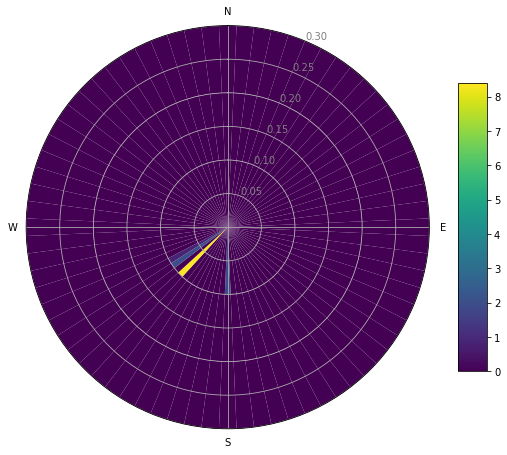

In [9]:
# choose number of fractions in plot (desirably 360 degree/N is an integer!)
N = 72
N2 = 30
abins = np.arange(N + 1) * 360. / N
sbins = np.linspace(0, 3, N2 + 1)
cmap = obspy_sequential

# sum rel power in bins given by abins and sbins
hist, baz_edges, sl_edges = \
    np.histogram2d(baz, slow, bins=[abins, sbins], weights=rel_power)

# transform to radian
baz_edges = np.radians(baz_edges)

# add polar and colorbar axes
fig = plt.figure(figsize=(8, 8))
cax = fig.add_axes([0.85, 0.2, 0.05, 0.5])
ax = fig.add_axes([0.10, 0.1, 0.70, 0.7], polar=True)
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")

dh = abs(sl_edges[1] - sl_edges[0])
dw = abs(baz_edges[1] - baz_edges[0])

# circle through backazimuth
for i, row in enumerate(hist):
    bars = ax.bar((i * dw) * np.ones(N2),height=dh * np.ones(N2),width=dw, bottom=dh * np.arange(N2),color=cmap(row / hist.max()))

ax.set_xticks(np.linspace(0, 2 * np.pi, 4, endpoint=False))
ax.set_xticklabels(['N', 'E', 'S', 'W'])

# set slowness limits
ax.set_ylim(0, 0.3)
[i.set_color('grey') for i in ax.get_yticklabels()]
ColorbarBase(cax, cmap=cmap,
             norm=Normalize(vmin=hist.min(), vmax=hist.max()))
plt.show()


In [10]:
baz_estimate = mode(baz)
print('Backazimuth',baz,'Velocity',1/slow,'Average Velocity',np.mean(1/slow))

Backazimuth [ 236.30993247  225.          236.30993247  225.          225.
  180.          180.          225.          225.          225.
  243.43494882  225.          225.          225.        ] Velocity [  6.93375245e+03   8.83883476e+03   6.93375245e+03   1.76776695e+04
   5.89255651e+03   1.00000000e+08   1.00000000e+08   8.83883476e+03
   1.76776695e+04   1.76776695e+04   1.11803399e+04   1.76776695e+04
   8.83883476e+03   8.83883476e+03] Average Velocity 14295500.4585


We see that the estimate of the backazimuth is correct while that of velocity is not, we'll reavaluate the above with randomized axes to get a more proper idea of velocity.

In [11]:
# Now storing this data with proper format in a .mseed file
st =Stream()
#for i in range(1,101,2):  # for odd receivers
for i in range(0,101,1): # for even receivers
    stats = {'network': 'SATLAB', 'station': 'GLEE', 'location':str(rec_x_pos[i])+','+str(rec_y_pos[i]) ,
             'coordsys': 'xy','coordinates':AttribDict({'x': rec_x_pos[i],'y': rec_y_pos[i],'elevation': 0}),
         'channel': 'WLZ', 'npts': len(z_data[0])-start_Index, 'sampling_rate': 810/20,
         'mseed': {'dataquality': 'D'}} # stats for receivers
    tr =Trace(data=z_data[i,start_Index:]*(-1)**np.random.randint(low=0,high=2), header=stats)   # creating a trace for 1 receiver
    st.append(tr)
    
#st.write('Exp_5.mseed') # storing data in .mseed file for later purposes

In [12]:
# A small code to extract end time from stream parameters and input in the arguments of function in required format
end_time_str=str(st[0].stats.endtime)
end_time= str()
for i in end_time_str:
    if i =='0' or i =='1' or i =='2' or i =='3' or i =='4' or i =='5' or i =='6' or i =='7'or i =='8'or i =='9'or i =='.':
        end_time = end_time + i


kwargs = dict(
    # slowness grid: X min, X max, Y min, Y max, Slow Step
    sll_x=-0.0004, slm_x=0.0004, sll_y=-0.0004, slm_y=0.0004, sl_s=0.00004,coordsys='xy',
    # sliding window properties
    win_len=1.0, win_frac=0.5,
    # frequency properties
    frqlow=0.5, frqhigh=5.0, prewhiten=0,
    # restrict output
    semb_thres=-1e9, vel_thres=-1e9,
    stime=obspy.UTCDateTime("19700101000000"),
    etime=obspy.UTCDateTime(end_time)
)   # arguments for array processing
out = array_processing(st, **kwargs)

In [13]:
# Separately storing time, rel_power,abs_power, backazimuth and slowness

t, rel_power, abs_power, baz, slow = out.T
baz[baz < 0.0] += 360   


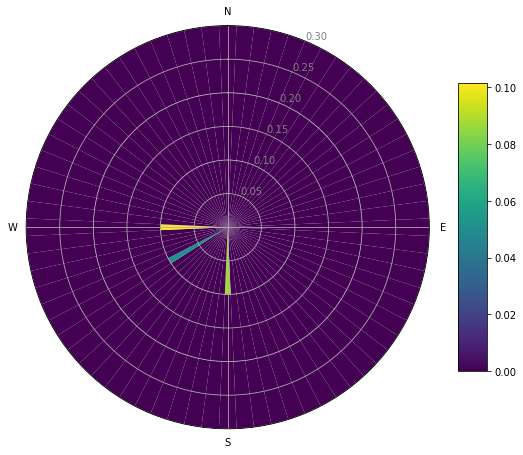

In [14]:
# choose number of fractions in plot (desirably 360 degree/N is an integer!)
N = 72
N2 = 30
abins = np.arange(N + 1) * 360. / N
sbins = np.linspace(0, 3, N2 + 1)
cmap = obspy_sequential

# sum rel power in bins given by abins and sbins
hist, baz_edges, sl_edges = \
    np.histogram2d(baz, slow, bins=[abins, sbins], weights=rel_power)

# transform to radian
baz_edges = np.radians(baz_edges)

# add polar and colorbar axes
fig = plt.figure(figsize=(8, 8))
cax = fig.add_axes([0.85, 0.2, 0.05, 0.5])
ax = fig.add_axes([0.10, 0.1, 0.70, 0.7], polar=True)
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")

dh = abs(sl_edges[1] - sl_edges[0])
dw = abs(baz_edges[1] - baz_edges[0])

# circle through backazimuth
for i, row in enumerate(hist):
    bars = ax.bar((i * dw) * np.ones(N2),height=dh * np.ones(N2),width=dw, bottom=dh * np.arange(N2),color=cmap(row / hist.max()))

ax.set_xticks(np.linspace(0, 2 * np.pi, 4, endpoint=False))
ax.set_xticklabels(['N', 'E', 'S', 'W'])

# set slowness limits
ax.set_ylim(0, 0.3)
[i.set_color('grey') for i in ax.get_yticklabels()]
ColorbarBase(cax, cmap=cmap,
             norm=Normalize(vmin=hist.min(), vmax=hist.max()))
plt.show()


In [15]:
vel_estimate = np.mean(1/slow)
print('Backazimuth',baz,'Velocity',1/slow,'Average Velocity',np.mean(1/slow))

Backazimuth [ 243.43494882  243.43494882  270.          180.          243.43494882
  180.          180.          270.          180.          180.
  270.          270.          270.          270.        ] Velocity [  1.11803399e+04   1.11803399e+04   2.50000000e+04   1.00000000e+08
   1.11803399e+04   1.00000000e+08   1.00000000e+08   2.50000000e+04
   1.00000000e+08   1.00000000e+08   2.50000000e+04   2.50000000e+04
   2.50000000e+04   2.50000000e+04] Average Velocity 35727395.7871


In [16]:
#Checking the results with subset breakage in sequence

baz_mean = np.zeros(10) # to store the mean back azimuth for each subset
baz_mode = np.zeros(10) # to store the most frequent back azimuth for each subset
slow_mod = np.zeros(10)
std_baz = np.zeros(10)
# We can create an additional loop to run throught the subsets
for i in range(10):
    st =Stream()
    for j in range(i*10,i*10+10):  # change the entries for a new subset
        r_index = j  
        stats = {'network': 'SATLAB', 'station': 'GLEE', 'location':str(rec_x_pos[r_index])+','+str(rec_y_pos[r_index]) ,
             'coordsys': 'xy','coordinates':AttribDict({'x': rec_x_pos[r_index],'y': rec_y_pos[r_index],'elevation': 0}),
             'channel': 'WLZ', 'npts': len(z_data[0]), 'sampling_rate': 17,
             'mseed': {'dataquality': 'D'}} # stats for receivers
        tr =Trace(data=z_data[r_index,start_Index:]*(-1)**np.random.randint(low=0,high=2), header=stats)   # creating a trace for 1 receiver
        st.append(tr)
    kwargs = dict(
        # slowness grid: X min, X max, Y min, Y max, Slow Step
        sll_x=-0.0004, slm_x=0.0004, sll_y=-0.0004, slm_y=0.0004, sl_s=0.00004,coordsys='xy',
        # sliding window properties
        win_len=1.0, win_frac=0.5,
        # frequency properties
        frqlow=0.1, frqhigh=5.0, prewhiten=0,
        # restrict output
        semb_thres=-1e9, vel_thres=-1e9,
        stime=obspy.UTCDateTime("19700101000000"),
        etime=obspy.UTCDateTime(end_time)
    )   # arguments for array processing
    out = array_processing(st, **kwargs)
    t, rel_power, abs_power, baz, slow = out.T
    baz[baz < 0.0] += 360
    app_velocity = 1/slow
    baz_vel_select = list()  # to store the backazimuth values based on velocity selection
    for k in range(np.size(baz)):
        if app_velocity[k] < 2100 and app_velocity[k] > 1900:
            baz_vel_select.append(baz[k])
        
            
    if np.size(baz_vel_select)>0:
        baz_mean[i] = np.mean(baz_vel_select)
    baz_mode[i] =mode(baz)[0] # only returning the mode
    slow_mod[i] = mode(slow)[0]
  

In [17]:
print('The mean backazimuth for the 10 subsets: ',baz_mean,'The overall mean is',np.mean(baz_mean))
print('The modal backazimuth for the 10 subsets: ',baz_mode,'The overall mean of the modes is',np.mean(baz_mode))
print('The modal velocities is',1/(slow_mod),'And the mean of modal velocities is',1/np.mean(slow_mod))

The mean backazimuth for the 10 subsets:  [  0.           0.           0.           0.           0.
   0.           0.           0.           0.          51.34019175] The overall mean is 5.13401917459
The modal backazimuth for the 10 subsets:  [ 135.           45.          180.           45.           45.
   45.          253.30075577    0.           84.28940686   45.        ] The overall mean of the modes is 87.7590162629
The modal velocities is [ 1767.76695297  1767.76695297  2500.          1767.76695297  1767.76695297
  1767.76695297  2394.56571305  2500.          2487.59297552  1767.76695297] And the mean of modal velocities is 1994.52708354
